In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import sys
sys.path.append('../src')
from torch import nn
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
pd.options.display.max_columns=100

In [27]:
step = (final_lr/start_lr)**(1/num_epochs)

/home/sahil_okcredit_in/miniconda3/envs/torch-py3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<AxesSubplot:>

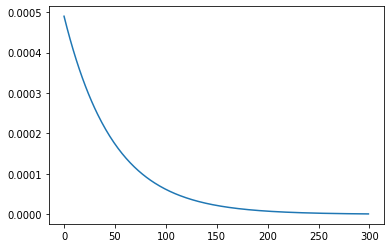

In [29]:
import torch
import torch.optim as optim

optimizer = optim.SGD([torch.rand((2,2), requires_grad=True)], lr=start_lr)
fun = lambda epoch: step
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=step)
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=1000)
val=[]
for epoch in range(num_epochs):
    scheduler.step()
#     print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    val.append(optimizer.param_groups[0]['lr'])
#     if epoch % 5 == 0:print()
pd.Series(val).plot()

In [30]:
np.min(val)

9.999999999999902e-07

In [32]:
sum([x<5e-5 for x in val])

189

In [8]:
start_lr*(step**num_epochs)

0.000999001497172706

In [60]:
from omegaconf import OmegaConf

In [62]:
config = OmegaConf.load('../configs/lstm-classification.yaml')

In [80]:
# lr_step_size = 1 - (config.start_lr - config.last_lr) / config.num_epochs
# lr_step_size

In [81]:
# (config.start_lr - config.last_lr) / config.num_epochs

In [83]:
# start_lr(1-step)

In [44]:
start_lr

0.0001

/home/sahil_okcredit_in/miniconda3/envs/torch-py3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<AxesSubplot:>

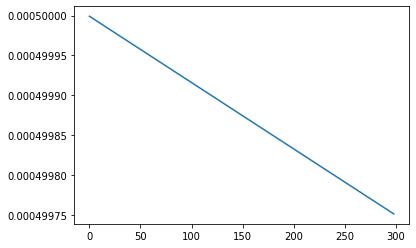

In [3]:
from datalib import VentilatorData,VentilatorData2
import modellib
from utils import fc,add_feature,add_lag_feature

In [4]:
DATA_DIR = '/mnt/disks/extra_data/kaggle/ventilator_prediction/'
R_MAP = {5: 0, 50: 1, 20: 2}
C_MAP = {20: 0, 50: 1, 10: 2}

In [21]:
train = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
# train.breath_id = train.breath_id.map(dict(zip(train.breath_id.unique().tolist(),range(train.breath_id.nunique()))))
# test.breath_id = test.breath_id.map(dict(zip(test.breath_id.unique().tolist(),range(test.breath_id.nunique()))))


In [22]:
%%time
train = add_feature(train)
train = add_lag_feature(train)

CPU times: user 16.2 s, sys: 3.01 s, total: 19.2 s
Wall time: 19.1 s


In [23]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,R_val,C_val,u_out_val,time_delta,delta,area,cross,cross2,u_in_cumsum,u_in_cummean,u_in_lag_1,u_in_time1,u_out_lag_1,u_in_lag_2,u_in_time2,u_out_lag_2,u_in_lag_3,u_in_time3,u_out_lag_3,u_in_lag_4,u_in_time4,u_out_lag_4,breath_time
0,1,1,20,50,0.000000,0.083334,0,5.837492,20,50,0,0.000000,0.000000,0.000000,0.0,0.0,0.083334,0.083334,0.000000,0.083334,0.0,0.000000,0.083334,0.0,0.000000,0.083334,0.0,0.000000,0.083334,0.0,0.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,20,50,0,0.033652,0.618632,0.618632,0.0,0.0,18.466375,9.233188,0.083334,18.299707,0.0,0.000000,18.383041,0.0,0.000000,18.383041,0.0,0.000000,18.383041,0.0,0.033652
2,3,1,20,50,0.067514,22.509278,0,7.876254,20,50,0,0.033862,0.762212,1.380843,0.0,0.0,40.975653,13.658551,18.383041,4.126236,0.0,0.083334,22.425944,0.0,0.000000,22.509278,0.0,0.000000,22.509278,0.0,0.067514
3,4,1,20,50,0.101542,22.808822,0,11.742872,20,50,0,0.034028,0.776134,2.156978,0.0,0.0,63.784476,15.946119,22.509278,0.299544,0.0,18.383041,4.425781,0.0,0.083334,22.725488,0.0,0.000000,22.808822,0.0,0.101542
4,5,1,20,50,0.135756,25.355850,0,12.234987,20,50,0,0.034213,0.867507,3.024485,0.0,0.0,89.140326,17.828065,22.808822,2.547028,0.0,22.509278,2.846573,0.0,18.383041,6.972809,0.0,0.083334,25.272516,0.0,0.034213


In [24]:
train.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'R_val', 'C_val', 'u_out_val', 'time_delta', 'delta', 'area', 'cross',
       'cross2', 'u_in_cumsum', 'u_in_cummean', 'u_in_lag_1', 'u_in_time1',
       'u_out_lag_1', 'u_in_lag_2', 'u_in_time2', 'u_out_lag_2', 'u_in_lag_3',
       'u_in_time3', 'u_out_lag_3', 'u_in_lag_4', 'u_in_time4', 'u_out_lag_4',
       'breath_time'],
      dtype='object')

In [27]:
train.shape

(6036000, 31)

In [29]:
train[(['R_val','C_val','u_out_val','time_step', 'u_in','time_delta', 'delta', 'area', 'cross', 'cross2', 'u_in_cumsum',
       'u_in_cummean', 'u_in_lag_1', 'u_in_time1', 'u_out_lag_1', 'u_in_lag_2',
       'u_in_time2', 'u_out_lag_2', 'u_in_lag_3', 'u_in_time3', 'u_out_lag_3',
       'u_in_lag_4', 'u_in_time4', 'u_out_lag_4', 'breath_time'])].shape

(6036000, 25)

In [8]:
# %%time
# train = fc(train)

In [7]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,mean_u_in_last_5,min_u_in_last_5,max_u_in_last_5,std_u_in_last_5,mean_u_in_last_10,min_u_in_last_10,max_u_in_last_10,std_u_in_last_10,mean_u_in_next_5,min_u_in_next_5,max_u_in_next_5,std_u_in_next_5,mean_u_in_next_10,min_u_in_next_10,max_u_in_next_10,std_u_in_next_10,u_in_cumsum,u_in_cummean,u_in_cummax,R+C,R/C,u_in/C,u_in/R,u_in_cumsum/C,u_in_cumsum/R,lag_u_in_1,lead_u_in_1,lag_u_in_2,lead_u_in_2,lag_u_in_3,lead_u_in_3,lag_u_in_4,lead_u_in_4,auc,lag_auc_1,lead_auc_1,lag_auc_2,lead_auc_2,per_change_u_in_lag_u_in_1,per_change_u_in_lead_u_in_1,per_change_u_in_lag_u_in_2,per_change_u_in_lead_u_in_2,per_change_u_in_lag_u_in_3,per_change_u_in_lead_u_in_3,per_change_u_in_lag_u_in_4,per_change_u_in_lead_u_in_4,per_change_auc_lag_auc_1,per_change_auc_lead_auc_1,per_change_auc_lag_auc_2,per_change_auc_lead_auc_2
79,1,0,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,0.083334,0.000000,0.083334,0.083334,0.083334,0.000000,17.828065,0.083334,25.355850,10.229525,22.651316,0.083334,28.313036,8.515846,0.083334,0.083334,0.083334,70,0.4,0.001667,0.004167,0.001667,0.004167,0.000000,18.383041,0.000000,22.509278,0.000000,22.808822,0.000000,25.355850,0.000000,0.000000,0.310718,0.000000,0.692350,0.999988,-219.592083,0.999988,-269.105925,0.999988,-272.700387,0.999988,-303.264110,0.000000,-310718.055487,0.000000,-692350.186987
78,2,0,20,50,0.033652,18.383041,0,5.907794,9.233188,0.083334,18.383041,12.939847,9.233188,0.083334,18.383041,12.939847,23.263372,18.383041,27.259866,3.351989,25.329658,18.383041,28.313036,3.151678,18.466375,9.233188,18.383041,70,0.4,0.367661,0.919152,0.369328,0.923319,0.083334,22.509278,0.000000,22.808822,0.000000,25.355850,0.000000,27.259866,0.310718,0.000000,0.692350,0.000000,0.771038,0.995467,-0.224459,1.000000,-0.240753,1.000000,-0.379307,1.000000,-0.482881,0.999997,-1.228222,0.999997,-1.481467
77,3,0,20,50,0.067514,22.509278,0,7.876254,13.658551,0.083334,22.509278,11.936136,13.658551,0.083334,22.509278,11.936136,25.012260,22.509278,27.259866,2.278378,26.167635,22.509278,28.313036,2.004828,40.975653,13.658551,22.509278,70,0.4,0.450186,1.125464,0.819513,2.048783,18.383041,22.808822,0.083334,25.355850,0.000000,27.259866,0.000000,27.127486,0.692350,0.310718,0.771038,0.000000,0.823936,0.183313,-0.013308,0.996298,-0.126462,1.000000,-0.211050,1.000000,-0.205169,0.551212,-0.113653,0.999999,-0.190057
76,4,0,20,50,0.101542,22.808822,0,11.742872,15.946119,0.083334,22.808822,10.766279,15.946119,0.083334,22.808822,10.766279,25.871951,22.808822,27.259866,1.872664,26.716034,22.808822,28.313036,1.602636,63.784476,15.946119,22.808822,70,0.4,0.456176,1.140441,1.275690,3.189224,22.509278,25.355850,18.383041,27.259866,0.083334,27.127486,0.000000,26.807732,0.771038,0.692350,0.823936,0.310718,0.892947,0.013133,-0.111669,0.194038,-0.195146,0.996346,-0.189342,1.000000,-0.175323,0.102054,-0.068607,0.597013,-0.158110
75,5,0,20,50,0.135756,25.355850,0,12.234987,17.828065,0.083334,25.355850,10.229525,17.828065,0.083334,25.355850,10.229525,26.883130,25.355850,27.864715,0.935871,27.114142,25.355850,28.313036,0.834682,89.140326,17.828065,25.355850,70,0.4,0.507117,1.267793,1.782807,4.457016,22.808822,27.259866,22.509278,27.127486,18.383041,26.807732,0.083334,27.864715,0.823936,0.771038,0.892947,0.692350,0.924862,0.100451,-0.075092,0.112265,-0.069871,0.274998,-0.057260,0.996713,-0.098946,0.064202,-0.083757,0.159704,-0.122491


In [9]:
# train = create_feats(train)
# test = create_feats(test)
train.R = train.R.map(R_MAP)
train.C = train.C.map(C_MAP)
test.R = test.R.map(R_MAP)
test.C = test.C.map(C_MAP)

In [11]:
# def create_feats(df_tmp):
#     c = 'u_in'
#     LAG_WINDOW_RANGE = range(3)
#     df_tmp = df_tmp.assign(**{f'{c}_t-{t}': df_tmp.groupby('breath_id')[c].shift(t) for t in LAG_WINDOW_RANGE})
#     use_fts = [f'{c}_t-{t}' for t in LAG_WINDOW_RANGE]    
#     df_tmp['u_in_lag_1'] = df_tmp.groupby('breath_id')['u_in'].shift(1).fillna(0)
#     df_tmp['u_in_lag_2'] = df_tmp.groupby('breath_id')['u_in'].shift(2).fillna(0)
#     df_tmp['u_in_cumsum'] = df_tmp.groupby('breath_id')['u_in'].cumsum()
#     df_tmp['u_in_cummean'] = df_tmp['u_in_cumsum']/(df_tmp.groupby('breath_id')['u_in'].cumcount() + 1)
#     df_tmp['u_in_cummax'] = df_tmp.groupby('breath_id')['u_in'].cummax()
#     df_tmp['next_u_in'] = df_tmp.groupby('breath_id')['u_in'].shift(-1).fillna(0)

#     df_tmp['roll_u_in_max'] = df_tmp[use_fts].max(axis=1).fillna(0)
#     df_tmp['roll_u_in_min'] = df_tmp[use_fts].min(axis=1).fillna(0)

#     df_tmp['time_lag_1'] = df_tmp.groupby('breath_id')['time_step'].shift(1).fillna(0)
#     df_tmp['time_lag_2'] = df_tmp.groupby('breath_id')['time_step'].shift(2).fillna(0)

#     df_tmp.drop(use_fts, axis=1, inplace=True)

#     df_tmp['area'] = df_tmp['time_step'] * df_tmp['u_in']
#     df_tmp['area'] = df_tmp.groupby('breath_id')['area'].cumsum()
    
#     df_tmp['u_out_lag_1'] = df_tmp.groupby('breath_id')['u_out'].shift(1).fillna(0)
#     df_tmp['u_out_lag_2'] = df_tmp.groupby('breath_id')['u_out'].shift(2).fillna(0)

#     df_tmp['time_step*u_out']= df_tmp['time_step']*df_tmp['u_out']


#     df_tmp['R+C'] = df_tmp['R'] + df_tmp['C']
#     df_tmp['R/C'] = df_tmp['R'] / df_tmp['C']
#     df_tmp['u_in/C'] = df_tmp['u_in'] / df_tmp['C']
#     df_tmp['u_in/R'] = df_tmp['u_in'] / df_tmp['R']
#     df_tmp['u_in_cumsum/C'] = df_tmp['u_in_cumsum'] / df_tmp['C']
#     df_tmp['u_in_cumsum/R'] = df_tmp['u_in_cumsum'] / df_tmp['R']
#     df_tmp['timestep_diff'] = (df_tmp['time_step'] - df_tmp.groupby('breath_id')['time_step'].shift(1)).fillna(0)
#     df_tmp['u_in_diff'] = (df_tmp['u_in'] - df_tmp.groupby('breath_id')['u_in'].shift(1)).fillna(0)
#     df_tmp['u_in_pct_change'] = (df_tmp['u_in_diff']/(df_tmp['u_in_lag_1'] + 1e-4)).fillna(0)
#     df_tmp['u_in_diff_next'] = (df_tmp['u_in'] - df_tmp.groupby('breath_id')['u_in'].shift(-1)).fillna(0)
#     df_tmp['u_in_log'] = np.log1p(df_tmp['u_in'])
#     df_tmp['u_in_cumsum_log'] = np.log1p(df_tmp['u_in_cumsum'])
#     return df_tmp

In [11]:
train.groupby('breath_id').head(40).head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,...,u_in/C,u_in/R,u_in_cumsum/C,u_in_cumsum/R,timestep_diff,u_in_diff,u_in_pct_change,u_in_diff_next,u_in_log,u_in_cumsum_log
0,1,0,2,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,...,0.001667,0.004167,0.001667,0.004167,0.000000,0.000000,0.000000,-18.299707,0.080043,0.080043
1,2,0,2,1,0.033652,18.383041,0,5.907794,0.083334,0.000000,...,0.367661,0.919152,0.369328,0.923319,0.033652,18.299707,219.331522,-4.126236,2.964399,2.968689
2,3,0,2,1,0.067514,22.509278,0,7.876254,18.383041,0.083334,...,0.450186,1.125464,0.819513,2.048783,0.033862,4.126236,0.224458,-0.299544,3.157395,3.737090
3,4,0,2,1,0.101542,22.808822,0,11.742872,22.509278,18.383041,...,0.456176,1.140441,1.275690,3.189224,0.034028,0.299544,0.013308,-2.547028,3.170056,4.171066
4,5,0,2,1,0.135756,25.355850,0,12.234987,22.808822,22.509278,...,0.507117,1.267793,1.782807,4.457016,0.034213,2.547028,0.111668,-1.904016,3.271690,4.501368


In [48]:
# group_dict={}
# for i,x in train.groupby('breath_id'):
#     group_dict[i] = x[['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']]

In [12]:
group_dict={}
for i,x in tqdm(train.groupby('breath_id'),total=train.breath_id.nunique()):
    m = x.to_dict(orient='records')
    group_dict[i] = {k:[a[k] for a in m] for k in [k for k in m[0].keys() if k not in ['id','breath_id']]}

100%|██████████| 75450/75450 [01:25<00:00, 879.23it/s]


In [11]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,0,2,1,0.000000,0.083334,0,5.837492
1,2,0,2,1,0.033652,18.383041,0,5.907794
2,3,0,2,1,0.067514,22.509278,0,7.876254
3,4,0,2,1,0.101542,22.808822,0,11.742872
4,5,0,2,1,0.135756,25.355850,0,12.234987


In [16]:
data = VentilatorData2(group_dict = group_dict, categorical_columns=['R','C'], 
        numerical_columns=['R','C','time_step', 'u_in'], target_column='pressure')
dl = DataLoader(dataset = data,batch_size=32)

In [19]:
m = next(iter(dl))

In [23]:
(torch.where(m["u_out"].view(-1) == 0)[0])

969

In [31]:
# train['pressure'].round(2).value_counts()

In [13]:
# train[['breath_id','R','C','time_step','u_in','u_out','pressure']].groupby('breath_id')
data = VentilatorData(group_dict = group_dict, categorical_columns=['u_out','R','C'], 
        numerical_columns=['time_step', 'u_in',
'u_in_lag_1', 'u_in_lag_2', 'u_in_cumsum', 'u_in_cummean',
'u_in_cummax', 'next_u_in', 'roll_u_in_max', 'roll_u_in_min',
'time_lag_1', 'time_lag_2', 'area', 'u_out_lag_1', 'u_out_lag_2',
'time_step*u_out', 'R+C', 'R/C', 'u_in/C', 'u_in/R', 'u_in_cumsum/C',
'u_in_cumsum/R', 'timestep_diff', 'u_in_diff', 'u_in_pct_change',
'u_in_diff_next', 'u_in_log', 'u_in_cumsum_log'], target_column='pressure')
dl = DataLoader(dataset = data,batch_size=32)

In [18]:
# config = OmegaConf.load('../configs/cnn-lstm-model.yaml')
config = OmegaConf.load('../configs/lstm-model.yaml')

In [14]:
%%time
m = next(iter(dl))

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.3 ms


In [19]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_cumsum,u_in_cummean,u_in_cummax,next_u_in,roll_u_in_max,roll_u_in_min,time_lag_1,time_lag_2,area,u_out_lag_1,u_out_lag_2,time_step*u_out,R+C,R/C,u_in/C,u_in/R,u_in_cumsum/C,u_in_cumsum/R,timestep_diff,u_in_diff,u_in_pct_change,u_in_diff_next,u_in_log,u_in_cumsum_log
0,1,0,2,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.083334,0.083334,0.083334,18.383041,0.083334,0.083334,0.000000,0.000000,0.000000,0.0,0.0,0.0,70,0.4,0.001667,0.004167,0.001667,0.004167,0.000000,0.000000,0.000000,-18.299707,0.080043,0.080043
1,2,0,2,1,0.033652,18.383041,0,5.907794,0.083334,0.000000,18.466375,9.233188,18.383041,22.509278,18.383041,0.083334,0.000000,0.000000,0.618632,0.0,0.0,0.0,70,0.4,0.367661,0.919152,0.369328,0.923319,0.033652,18.299707,219.331522,-4.126236,2.964399,2.968689
2,3,0,2,1,0.067514,22.509278,0,7.876254,18.383041,0.083334,40.975653,13.658551,22.509278,22.808822,22.509278,0.083334,0.033652,0.000000,2.138333,0.0,0.0,0.0,70,0.4,0.450186,1.125464,0.819513,2.048783,0.033862,4.126236,0.224458,-0.299544,3.157395,3.737090
3,4,0,2,1,0.101542,22.808822,0,11.742872,22.509278,18.383041,63.784476,15.946119,22.808822,25.355850,22.808822,18.383041,0.067514,0.033652,4.454391,0.0,0.0,0.0,70,0.4,0.456176,1.140441,1.275690,3.189224,0.034028,0.299544,0.013308,-2.547028,3.170056,4.171066
4,5,0,2,1,0.135756,25.355850,0,12.234987,22.808822,22.509278,89.140326,17.828065,25.355850,27.259866,25.355850,22.509278,0.101542,0.067514,7.896588,0.0,0.0,0.0,70,0.4,0.507117,1.267793,1.782807,4.457016,0.034213,2.547028,0.111668,-1.904016,3.271690,4.501368


In [35]:
conv = nn.ModuleList([nn.Conv1d(28,32,3,padding=1),nn.Conv1d(28,32,5,padding=2),nn.Conv1d(28,32,1,padding=0)])

In [36]:
feats=[]
for mod in conv:
    feats.append(mod(m['num'].permute(0,2,1)))

torch.Size([32, 96, 80])

In [67]:
from modellib import LSTMModelV2

In [68]:
mod = LSTMModelV2(config.model.kwargs)

In [43]:
rnn = LSTMUnit(input_size = 96,hidden_size=512,bidirectional=True,dropout=0,batch_first=True,output_size=512,num_layers = 1)

In [44]:
rnn(torch.cat(feats,dim=1).permute(0,2,1)).shape

torch.Size([32, 80, 512])

In [22]:
len(config.dataset.train.kwargs.numerical_columns)

28

In [3]:
16 if config.mp_training else 32

32

In [44]:
mod = getattr(modellib,config.model['class'])(config.model.kwargs)

{'init_type': 'yakama'}
tensor(-27.4636)
tensor(-123.4334)


In [30]:
from model import InitRNNWeights

In [31]:
wt_init = InitRNNWeights('xavier')

In [32]:
torch.tensor([x.sum() for name,x in mod.rnn.named_parameters()]).sum()

tensor(19.8463)

In [33]:
wt_init(mod.rnn)

In [34]:
torch.tensor([x.sum() for name,x in mod.rnn.named_parameters()]).sum()

tensor(-133.8416)

In [38]:
# mod.cnn

Sequential(
  (0): Conv1DBnRelu(
    (conv): Conv1d(28, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU(inplace=True)
  )
  (1): Conv1DBasicBlock(
    (conv1): Conv1DBnRelu(
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (conv2): Conv1DBnRelu(
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
  )
  (2): Conv1DBnRelu(
    (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [15]:
# mod(m)

In [16]:
# m['cat'][:,:,2].view(-1)

In [17]:
# idx =torch.where(m['cat'][:,:,2].view(-1)==0)[0]